In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def is_flake_of_stone(flake_id, stone_id) -> bool:
    return flake_id[:-2] == stone_id

def z_score_normalize(data):
    # normalize 1D data array
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = (data - mean) / std_dev
    return normalized_data

In [4]:
LETTERS = ['a', 'b', 'c', 'd', 'e', 'f',]

def create_graph(dataset, data_collection, stone_id):
    # create Graph for stone_id with node values from data_collection
    G = nx.DiGraph()
    data_index = 0
    for index, row in dataset.iterrows():
        if is_flake_of_stone(row['Sample_ID'], stone_id):
            weight = data_collection[stone_id]["weight"][data_index]
            volume = data_collection[stone_id]["volume"][data_index]
            surface = data_collection[stone_id]["surface"][data_index]
            scar_count = data_collection[stone_id]["scar_count"][data_index]
            data_index += 1
            G.add_node(row['Sample_ID'], weight= weight, volume=volume, surface=surface, scar_count=scar_count)
    for index, row in dataset.iterrows():
        if is_flake_of_stone(row['Sample_ID'], stone_id):
            for l in LETTERS:
                if row[f'Subsequent_removal_{l}'] == row[f'Subsequent_removal_{l}']:
                    G.add_edge(row['Sample_ID'], row[f'Subsequent_removal_{l}'])
    return G

In [5]:
def read_and_normalize_property_data(dataset, stone_ids):
    # collect continuous data and normalize
    data_collection = {}
    for id in stone_ids:
        data_collection[id] = {"weight": [],
                                "volume": [],
                                "surface": [],
                                "scar_count": []}
        
    for index, row in dataset.iterrows():
        id = row['Sample_ID'][:-2]
        if id not in stone_ids:
            continue
        data_collection[id]["surface"].append(row['Surface_Area_mm^2']) 
        data_collection[id]["volume"].append(row['Volume_mm^3'])
        data_collection[id]["weight"].append(row['Weight_g'])
        data_collection[id]["scar_count"].append(row['Dorsal_scar_count'])
        
    for stone_id, data in data_collection.items():
        for prop, values in data.items():
            values = np.array(values)
            #Find indices that you need to replace
            inds = np.where(np.isnan(values))
            values[inds] = np.nanmedian(values)
            # normalize the data (after replacing nans)
            values = z_score_normalize(values)  
            data_collection[stone_id][prop] = values
    return data_collection

In [6]:
stone_ids = ['BT.1.4-25.','BT.1.A.','BT.1.C.','BT.1.F.','BT.2.65.','BT.2.UUU.']

filename = 'Melton_sequence_data_sample.xlsx'

dataset = pd.read_excel(filename, sheet_name='SAMPLE_DATA')

data_collection = read_and_normalize_property_data(dataset, stone_ids)

graphs = {}
for stone_id in stone_ids:
    G = create_graph(dataset, data_collection, stone_id)
    graphs[stone_id] = G

/home/jp/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [7]:
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.01'])
print(graphs['BT.1.4-25.'].nodes['BT.1.4-25.02'])

{'weight': -1.2180483097769272, 'volume': -1.1911143764992376, 'surface': -1.1744540461012496, 'scar_count': -1.5811388300841895}
{'weight': -0.2074651269483694, 'volume': -0.22075766124706597, 'surface': -0.22886632197670045, 'scar_count': 0.0}


In [8]:
for id, g in graphs.items():
    for node in g.nodes:
        print(g.nodes[node])

{'weight': -1.2180483097769272, 'volume': -1.1911143764992376, 'surface': -1.1744540461012496, 'scar_count': -1.5811388300841895}
{'weight': -0.2074651269483694, 'volume': -0.22075766124706597, 'surface': -0.22886632197670045, 'scar_count': 0.0}
{'weight': -0.2074651269483694, 'volume': -0.22075766124706597, 'surface': -0.22886632197670045, 'scar_count': 0.0}
{'weight': -0.2074651269483694, 'volume': -0.22075766124706597, 'surface': -0.22886632197670045, 'scar_count': 1.5811388300841895}
{'weight': 1.8404436906220363, 'volume': 1.8533873602404356, 'surface': 1.8610530120313542, 'scar_count': 0.0}
{'weight': nan, 'volume': 1.4425292243013406, 'surface': 1.5030294779510316, 'scar_count': 0.9622504486493764}
{'weight': nan, 'volume': 1.3883970537372545, 'surface': 1.6902966502244718, 'scar_count': -1.8970080273373418}
{'weight': nan, 'volume': -0.12076136507100467, 'surface': 0.32575092805665395, 'scar_count': -0.4673787893439827}
{'weight': nan, 'volume': 0.196897871754267, 'surface': 0.

In [9]:
def remove_undirected_edges(G):
    rem = set()
    for x, y in G.edges:
        if (y,x) in G.edges:
            rem.add((x,y))
            rem.add((y,x))
    for x,y in rem:
        G.remove_edge(x,y)

In [10]:
remove_undirected_edges(graphs['BT.1.4-25.'])

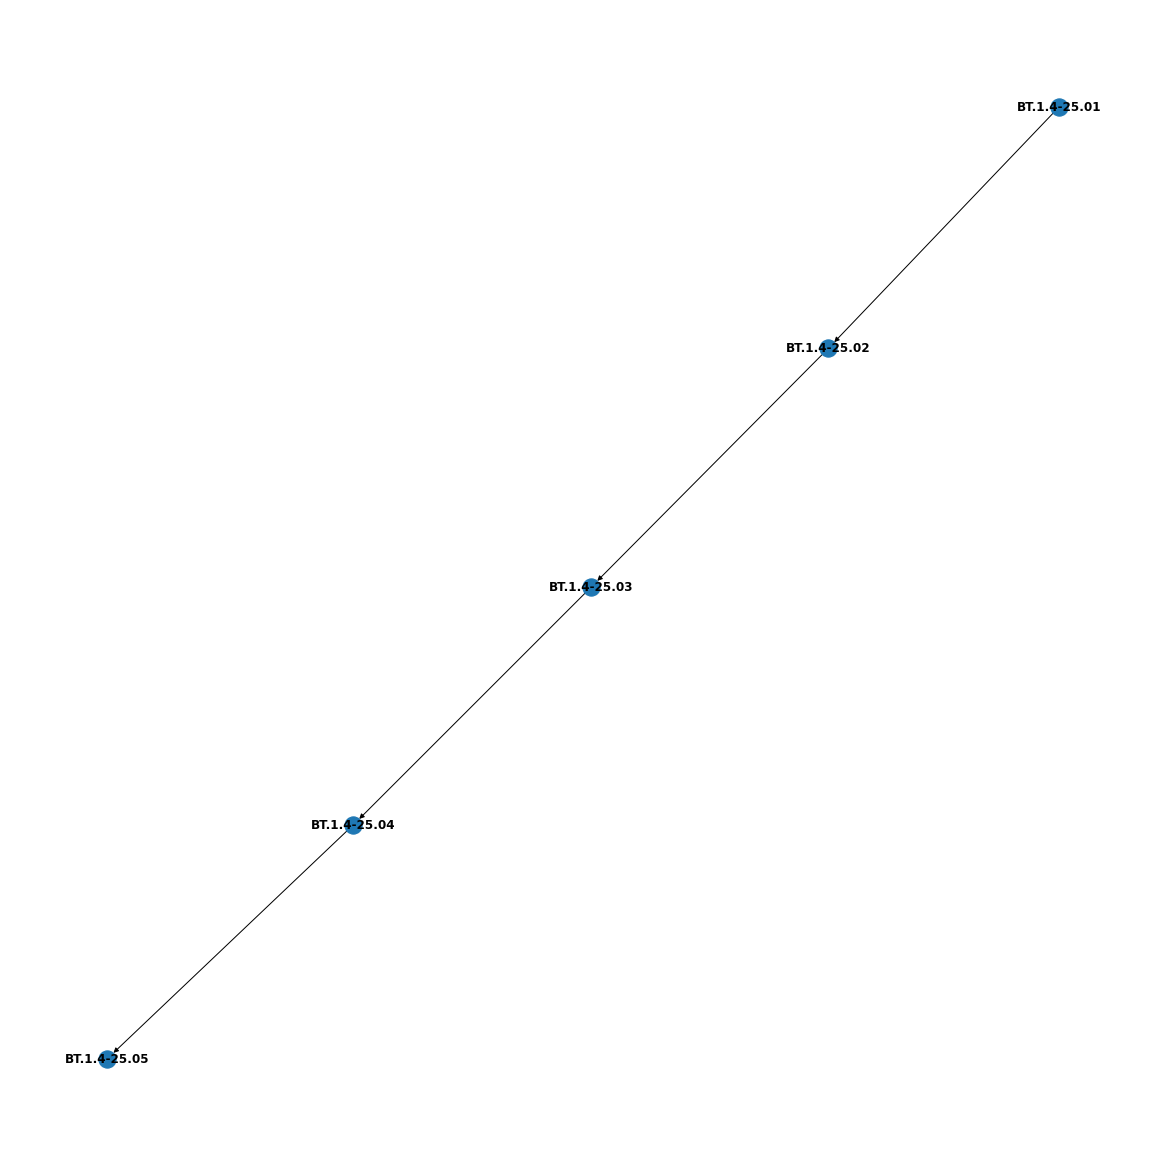

In [11]:
plt.figure(figsize=(16,16))
nx.draw(graphs['BT.1.4-25.'], pos=nx.kamada_kawai_layout(graphs['BT.1.4-25.']), with_labels=True, font_weight='bold')
plt.show()